In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import numpy.ma as ma
from matplotlib import gridspec

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# import nitrate data

argo = pd.read_csv('../data/argo/kuro_NO_argo.txt', sep = ',')

month = []
for n in range(len(argo)):
    month.append(np.int(str(argo['Date/GMT'][n]).split('/')[0].lstrip('0   ')))

argo['MONTH'] = month
argo = argo[(argo['LON']>140) & (argo['LON']<170) & (argo['LAT']>30) & (argo['LAT']<45)]

print argo.columns


Index([u'Date/GMT', u'Days since 1/1/1900', u'NITRATE[uMOL/KG]', u'DEPTH[M]',
       u'PRESSURE[DBAR]', u'NA', u'SALINITY[PSS]', u'TEMPERATURE[C]',
       u'SIGMATHETA[KG/M3]', u'OXYGEN[uMOL/KG]', u'OXYGENSAT', u'LON', u'LAT',
       u'MONTH'],
      dtype='object')


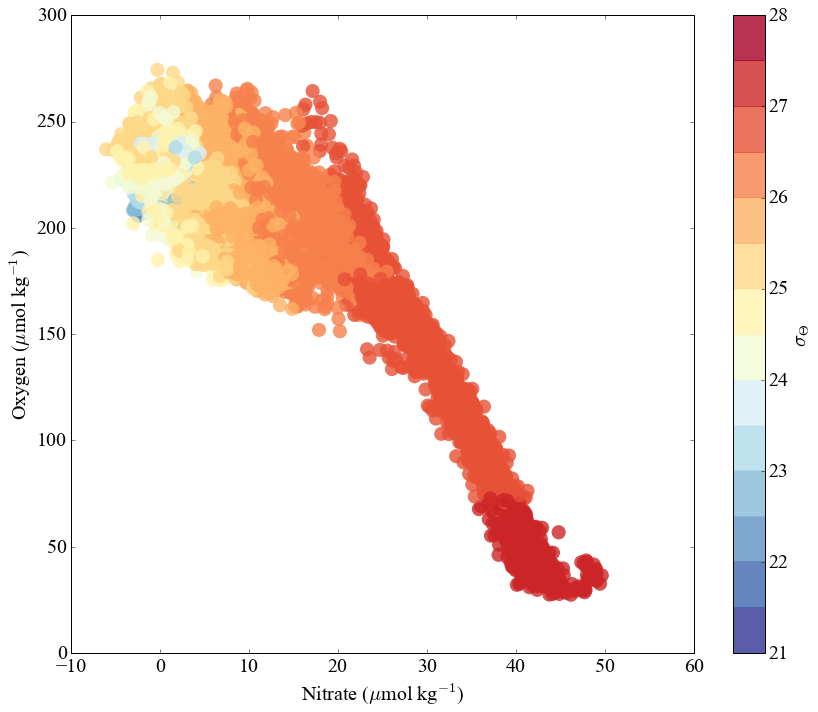

In [24]:
subset = argo[(argo['OXYGEN[uMOL/KG]']<1000)]# & (argo['DEPTH[M]']>=-250) & (argo['MONTH']>3) & (argo['MONTH']<10)]

palette = plt.get_cmap('RdYlBu_r', 14)

fig1 = plt.figure(1, figsize=(12,10))
plt.scatter(subset['NITRATE[uMOL/KG]'].values,subset['OXYGEN[uMOL/KG]'].values, c = subset['SIGMATHETA[KG/M3]'].values, lw=0, s = 200, cmap = palette, vmin = 21,vmax = 28, alpha = 0.8)

plt.ylabel('Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 20)
plt.xlabel('Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 20)
plt.tick_params(labelsize=20)

cb = plt.colorbar(ticks = range(21, 29))
cb.set_label(r'$\sigma_{\Theta}$', fontsize = 20)
cb.ax.tick_params(labelsize=20)

plt.show()


88


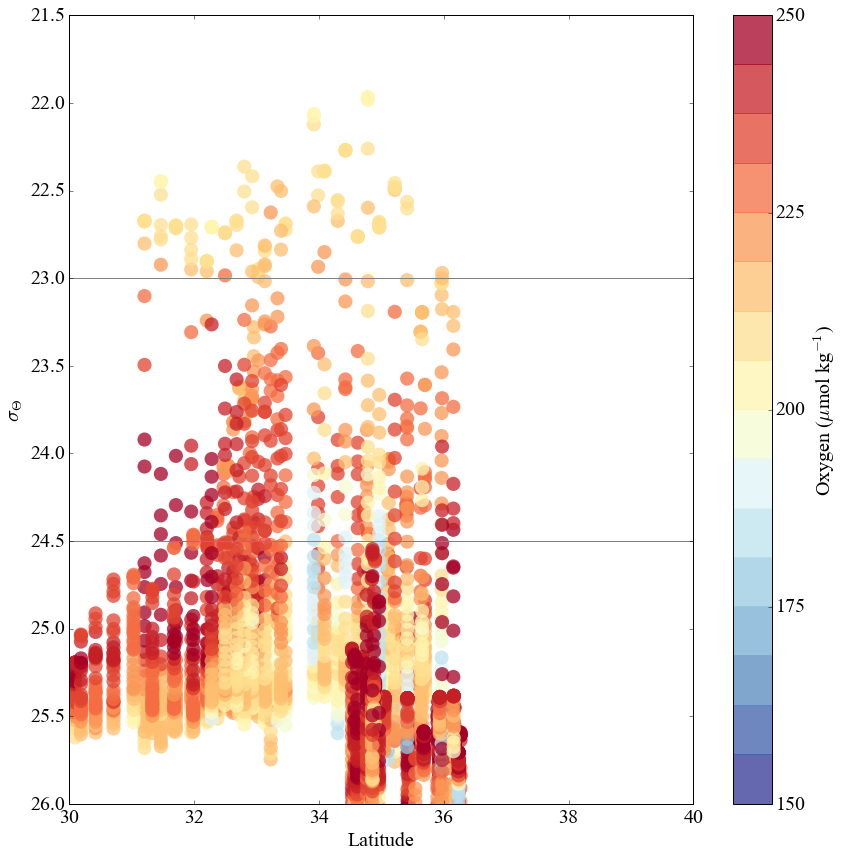

In [4]:
#subset = argo[(argo['DEPTH[M]']>=-150) & (argo['MONTH']>3) & (argo['MONTH']<10)]
 
fig1 = plt.figure(1, figsize=(12,12))

palette = plt.get_cmap('RdYlBu_r', 16)

#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['MONTH'], s=200, vmin = 1, vmax = 12, lw=0, alpha = 0.75)
plt.scatter(subset['LAT'],subset['SIGMATHETA[KG/M3]'], c = subset['OXYGEN[uMOL/KG]'], s=200, vmin = 150, vmax = 250, lw=0, alpha = 0.75, cmap = palette)
print len(pd.unique(subset['Days since 1/1/1900']))

#plt.contour()
cb = plt.colorbar(ticks = range(150, 251,25))
cb.set_label('Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 20)
plt.gca().invert_yaxis()
plt.axis([ 30,40, 26, 21.5])

plt.axhline(23, color='grey')
plt.axhline(24.5, color='grey') 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)

plt.show()

#fig1.savefig('../figures/argo_nitrate_sigma_t.png', bbox_inches='tight', dpi=600)

In [5]:
# bin the nitrate data into sigma vs latitude bins

dy = 0.125
dx = 1./3

ybin = np.arange(21., 27., dy)
xbin = np.arange(30., 38., dx)

xgrid, ygrid = np.meshgrid(xbin, ybin, sparse=False, indexing='ij')

binned2 = np.empty([len(xbin), len(ybin)])
numobs2 = np.empty([len(xbin), len(ybin)])
binnedstd2 = np.empty([len(xbin), len(ybin)])
fvar = 'OXYGEN[uMOL/KG]'

for i in range(len(xbin)):
    lat = xbin[i]
    for j in range(len(ybin)):
        sig = ybin[j]

        nn = len(subset.loc[((subset['LAT']>lat-dx/2) & (subset['LAT']<lat +dx/2) & (subset['SIGMATHETA[KG/M3]']>sig -dy/2)
                                        & (subset['SIGMATHETA[KG/M3]']<sig +dy/2)), fvar].values)

        if nn > 0:
            binned2[i,j] = np.nanmean(subset.loc[((subset['LAT']>lat-dx/2) & (subset['LAT']<lat +dx/2) & (subset['SIGMATHETA[KG/M3]']>sig -dy/2)
                                        & (subset['SIGMATHETA[KG/M3]']<sig +dy/2)), fvar].values)
            binnedstd2[i,j] = np.nanstd(subset.loc[((subset['LAT']>lat-dx/2) & (subset['LAT']<lat +dx/2) & (subset['SIGMATHETA[KG/M3]']>sig -dy/2)
                                        & (subset['SIGMATHETA[KG/M3]']<sig +dy/2)), fvar].values)
            numobs2[i,j] = nn
        else:
            binned2[i,j] = np.nan
            binnedstd2[i,j] = np.nan
            numobs2[i,j] = 0


In [6]:
# bin the nitrate data into sigma vs latitude bins

dy = 0.125
dx = 1./3

ybin = np.arange(21., 27., dy)
xbin = np.arange(30., 38., dx)

xgrid, ygrid = np.meshgrid(xbin, ybin, sparse=False, indexing='ij')

binned = np.empty([len(xbin), len(ybin)])
numobs = np.empty([len(xbin), len(ybin)])
binnedstd = np.empty([len(xbin), len(ybin)])
fvar = 'NITRATE[uMOL/KG]'

for i in range(len(xbin)):
    lat = xbin[i]
    for j in range(len(ybin)):
        sig = ybin[j]

        nn = len(subset.loc[((subset['LAT']>lat-dx/2) & (subset['LAT']<lat +dx/2) & (subset['SIGMATHETA[KG/M3]']>sig -dy/2)
                                        & (subset['SIGMATHETA[KG/M3]']<sig +dy/2)), fvar].values)

        if nn > 0:
            binned[i,j] = np.nanmean(subset.loc[((subset['LAT']>lat-dx/2) & (subset['LAT']<lat +dx/2) & (subset['SIGMATHETA[KG/M3]']>sig -dy/2)
                                        & (subset['SIGMATHETA[KG/M3]']<sig +dy/2)), fvar].values)
            binnedstd[i,j] = np.nanstd(subset.loc[((subset['LAT']>lat-dx/2) & (subset['LAT']<lat +dx/2) & (subset['SIGMATHETA[KG/M3]']>sig -dy/2)
                                        & (subset['SIGMATHETA[KG/M3]']<sig +dy/2)), fvar].values)
            numobs[i,j] = nn
        else:
            binned[i,j] = np.nan
            binnedstd[i,j] = np.nan
            numobs[i,j] = 0


88


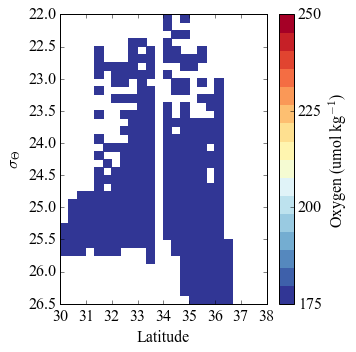

In [12]:
fig1 = plt.figure(1, figsize=(5,5), dpi = 300)
#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)

palette = plt.get_cmap('RdYlBu_r', 16)

binned2 = ma.masked_where(np.isnan(binned2), binned2)
binnedstd2 = ma.masked_where(np.isnan(binnedstd2), binnedstd2)

plt.pcolor(xgrid, ygrid, binned, vmin = 175, vmax = 250, lw=0, cmap = palette)
print len(pd.unique(subset['Days since 1/1/1900']))

#plt.contour()
cb = plt.colorbar(ticks = range(175,251,25))
cb.set_label('Oxygen (umol kg$^{-1}$)', fontsize = 16)
#cb.set_label('Nitrate C.V.', fontsize = 20)
plt.gca().invert_yaxis()
plt.axis([ 30,38, 26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

#plt.axvline(32.66, color='grey', lw=2)
#plt.axvline(34.66, color='grey', lw=2) 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 16)
plt.xlabel('Latitude', fontsize = 16)
plt.tick_params(labelsize=16)
cb.ax.tick_params(labelsize=16)

plt.show()

#fig1.savefig('../figures/kuro_argo_no3_binned.png', dpi=300)

88


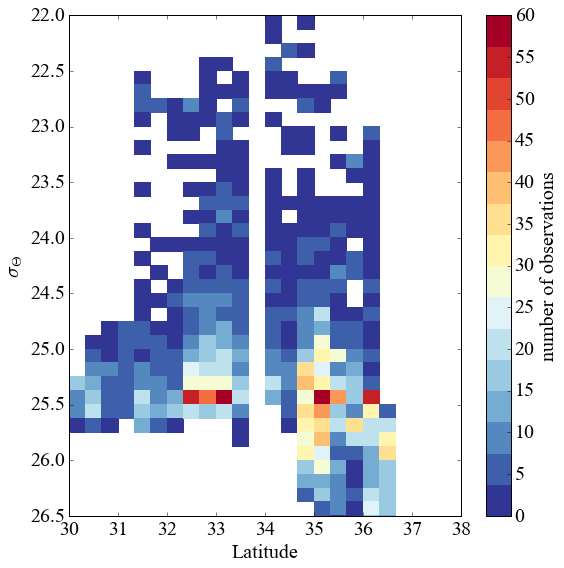

In [13]:
fig1 = plt.figure(1, figsize=(8,8))
#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)

palette = plt.get_cmap('RdYlBu_r', 16)

numobs = ma.masked_where(np.isnan(binned), numobs)

plt.pcolor(xgrid, ygrid, numobs, vmin = 0, vmax = 60, lw=0, cmap = palette)
print len(pd.unique(subset['Days since 1/1/1900']))

#plt.contour()
cb = plt.colorbar(ticks = range(0, 61, 5))
cb.set_label('number of observations', fontsize = 20)
plt.gca().invert_yaxis()
plt.axis([ 30,38, 26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

#plt.axvline(32.66, color='grey', lw=2)
#plt.axvline(34.66, color='grey', lw=2) 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)

plt.show()

#fig1.savefig('../figures/kuro_argo_no3_binned.png', bbox_inches='tight', dpi=300)

In [14]:
# # get may data only
# subset = argo[(argo['DEPTH[M]']>=-100)]# & (argo['MONTH']==5)]

# days = pd.unique(subset['Days since 1/1/1900'])
# print len(days)

# fig1 = plt.figure(1, figsize=(9,15))

# for d in days:
#     subsetd = subset[subset['Days since 1/1/1900']==d]
#     #print np.max(np.diff(subsetd['NITRATE[UMOL/KG]'].values)/np.diff(subsetd['DEPTH[M]']*-1))>0.005
    
#     plt.plot(subsetd['NITRATE[UMOL/KG]'], subsetd['DEPTH[M]'], lw = 2)
# plt.axis([-5, 15, -100, 0])
# plt.show()

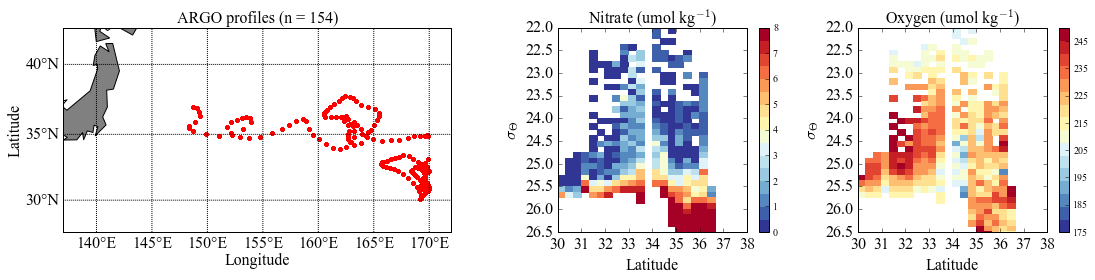

In [18]:
days = pd.unique(argo['Days since 1/1/1900'])

fig1 = plt.figure(figsize=(16, 4))

gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1,1]) 
ax1 = plt.subplot(gs[0])

m = Basemap(projection='merc',llcrnrlat=27.5,urcrnrlat=42.5,\
            llcrnrlon=137,urcrnrlon=172,lat_ts=0,resolution='c', ax = ax1)

m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')

for d in days:
    subsetd = argo[argo['Days since 1/1/1900']==d]
    x, y = m(subsetd['LON'].values, subsetd['LAT'].values)
    m.plot(x, y, '.-', color = 'r')
    
m.drawparallels(np.arange(-50,80,5),labels=[1,0,0,1], fontsize=16)
m.drawmeridians(np.arange(-180,180,5),labels=[0,0,0,1], fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('Longitude', fontsize = 16, labelpad = 20)
plt.ylabel('Latitude', fontsize = 16, labelpad = 40)

ax1.set_title('ARGO profiles (n = 154)', fontsize = 16)

ax2 = plt.subplot(gs[1])

palette = plt.get_cmap('RdYlBu_r', 16)
cb = ax2.pcolor(xgrid, ygrid, binned, vmin = 0, vmax = 8, lw=0, cmap = palette)
#plt.contour()
fig1.colorbar(cb, ax=ax2, ticks = range(0, 9))

ax2.invert_yaxis()
ax2.set_xlim([30, 38])
ax2.set_ylim([26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

#plt.axvline(32.66, color='grey', lw=2)
#plt.axvline(34.66, color='grey', lw=2) 

ax2.set_ylabel(r'$\sigma_{\Theta}$', fontsize = 16)
ax2.set_xlabel('Latitude', fontsize = 16)


ax2.set_title('Nitrate (umol kg$^{-1}$)', fontsize = 16)
ax2.tick_params(labelsize=16)

ax3 = plt.subplot(gs[2])

palette = plt.get_cmap('RdYlBu_r', 16)
cb = ax3.pcolor(xgrid, ygrid, binned2, vmin = 175, vmax = 250, lw=0, cmap = palette)
#plt.contour()
fig1.colorbar(cb, ax=ax3, ticks = range(175, 251, 10))

ax3.invert_yaxis()
ax3.set_xlim([30, 38])
ax3.set_ylim([26.5, 22.0])

ax3.set_ylabel(r'$\sigma_{\Theta}$', fontsize = 16)
ax3.set_xlabel('Latitude', fontsize = 16)


ax3.set_title('Oxygen (umol kg$^{-1}$)', fontsize = 16)
ax3.tick_params(labelsize=16)

plt.show()

fig1.savefig('../figures/kuro_argo_no3_o2_map.png', dpi=300)